### Morisita overlap index heatmap

In [116]:
def morisita_index(matrix):
    n = matrix.shape[0]
    I = np.zeros((n, n))  #Morisita Index matrix

    for i in range(n):
        for j in range(n):
            if i == j:
                I[i, j] = 1.0
            else:
                X_total = matrix[i, i]
                Y_total = matrix[j, j]

                X_shared = matrix[i, j]
                Y_shared = matrix[j, i]

                # Sum of products of shared cells
                sum_Xi_Yi = X_shared * Y_shared

                # Sum of Xi(Xi - 1) for site i
                sum_Xi_Xi_minus_1 = (X_total - X_shared) * (X_total - X_shared - 1) + X_shared * (X_shared - 1)

                # Sum of Yi(Yi - 1) for site j
                sum_Yi_Yi_minus_1 = (Y_total - Y_shared) * (Y_total - Y_shared - 1) + Y_shared * (Y_shared - 1)

                # Handle case where denominator might be zero
                if sum_Xi_Xi_minus_1 + sum_Yi_Yi_minus_1 == 0:
                    I[i, j] = 1.0 if X_total == Y_total else 0.0
                else:
                    # Morisita Overlap Index formula
                    I[i, j] = (2 * sum_Xi_Yi) / (sum_Xi_Xi_minus_1 + sum_Yi_Yi_minus_1)
                    
    return I

            L       IEL        LP        PB
L    1.000000  0.002282  0.007391  0.005832
IEL  0.002282  1.000000  0.031972  0.000558
LP   0.007391  0.031972  1.000000  0.000085
PB   0.005832  0.000558  0.000085  1.000000
            L       IEL        LP        PB
L    1.000000  0.002389  0.022264  0.189536
IEL  0.002389  1.000000  0.031521  0.000259
LP   0.022264  0.031521  1.000000  0.013444
PB   0.189536  0.000259  0.013444  1.000000
            L       IEL        LP        PB
L    1.000000  0.058186  0.051266  0.002580
IEL  0.058186  1.000000  0.289366  0.000541
LP   0.051266  0.289366  1.000000  0.000629
PB   0.002580  0.000541  0.000629  1.000000


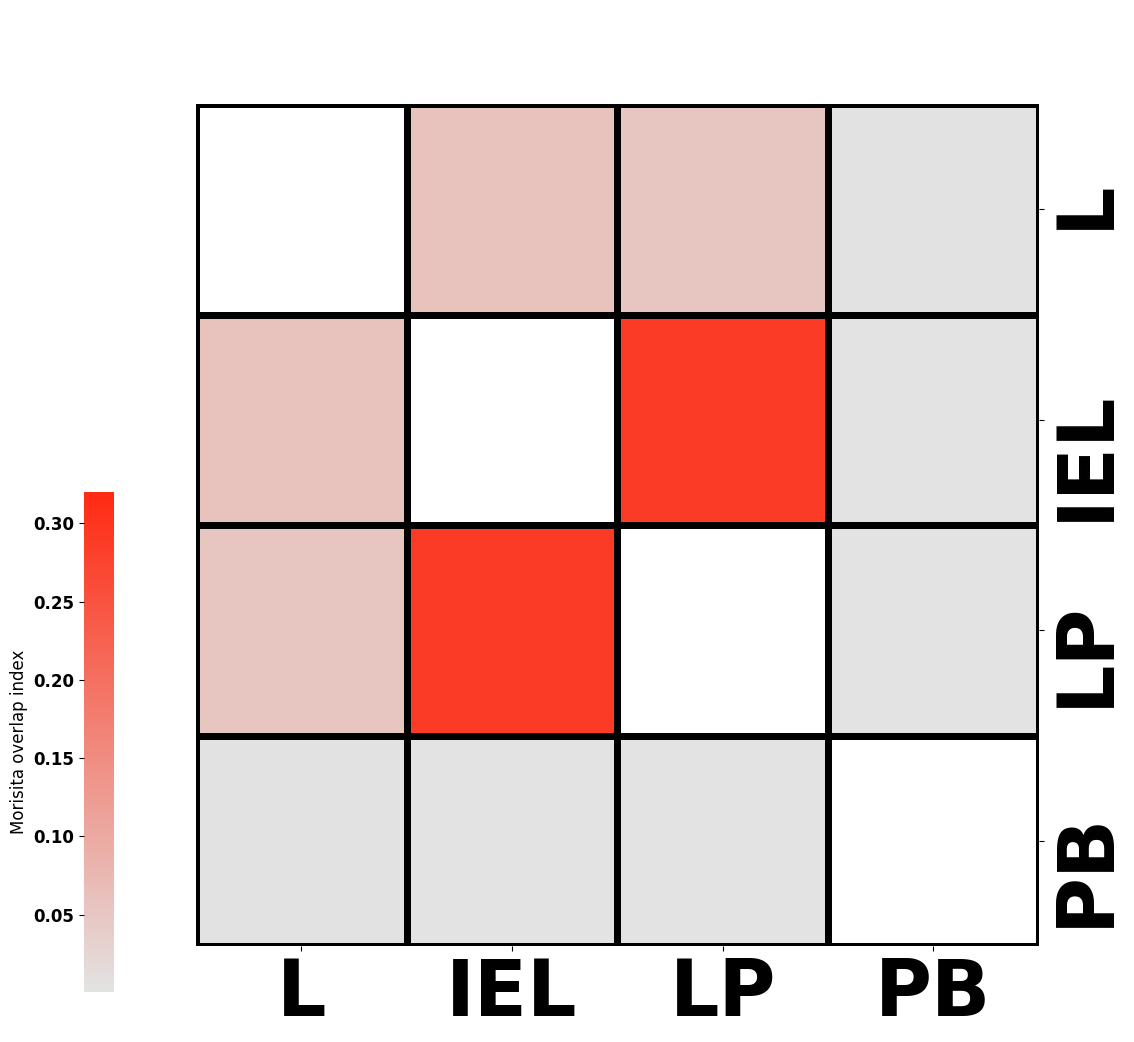

In [127]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[8,8]})
plt.rcParams['axes.linewidth'] = 2
for i in [0,1,2]:
    plt.close()
    tissues = set( adatas[i].obs['tissue'])
    df = adatas[i].obs[['tissue','clone']]
    clone_migrations = df.groupby(['clone', 'tissue']).size().unstack().fillna(0)  
    migration_counts = pd.DataFrame(index=list(tissues), columns=list(tissues))
    for tissue1 in tissues:
        for tissue2 in tissues:
            migration_counts.loc[tissue1, tissue2] = sum(clone_migrations.iloc[np.array((clone_migrations[tissue1] > 0) & (clone_migrations[tissue2] > 0)),:][tissue1])      
    migration_counts_mat = migration_counts.values.astype(int)
    
    I = morisita_index(migration_counts_mat)
    
    
    index_mat = pd.DataFrame(I,index=migration_counts.index, columns=migration_counts.columns)
    print(index_mat)
    mask = np.zeros_like(migration_counts, dtype=np.bool)
    np.fill_diagonal(mask, 1)
    clustergrid = sns.clustermap(index_mat,cmap = my_cmap,mask = mask, linewidths=5,linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 1,
                                 row_cluster= False, col_cluster = False,vmax = 0.32,
                                 cbar_kws={'label': 'Morisita overlap index','location':"left"})
    for a in clustergrid.ax_row_dendrogram.collections:
        a.set_linewidth(0)

    for a in clustergrid.ax_col_dendrogram.collections:
        a.set_linewidth(3)
    

    clustergrid.ax_cbar.set_position([0, 0, 0.03, 0.5])
    #.yaxis.set_label_coords(cbar.x0 + cbar.width + 2.7 , hm.y0 + height/2)    
    #x0, _y0, _w, _h = clustergrid.cbar_pos
    #clustergrid.ax_cbar.set_position([x0, 0.9, clustergrid.ax_row_dendrogram.get_position().width, 0.02])
        
    clustergrid.ax_heatmap.set_xticklabels(clustergrid.ax_heatmap.get_xmajorticklabels(), fontsize = 56)
    clustergrid.ax_heatmap.set_yticklabels(clustergrid.ax_heatmap.get_ymajorticklabels(), fontsize = 56)
    plt.tight_layout()
    #plt.show()
    plt.savefig('migration_heatmap_tissue_donnor_'+str(i+3)+'.png',dpi = 300,bbox_inches='tight')

### Clone numbers shared between sites

In [58]:
results = dict()
for i in [0,1,2]:
    for gtype in set(adatas[i].obs['general type']):
        
        adata_temp = adatas[i][np.array(np.array(adatas[i].obs['general type']== gtype) & np.array(adatas[i].obs['general subtype'] != 'MAIT')),:]
        df = adata_temp.obs[['tissue+celltype','clone']]
        clone_migrations = df.groupby(['clone', 'tissue+celltype']).size().unstack().fillna(0)
        nodes = set( adata_temp.obs['tissue+celltype'])
        migration_counts = pd.DataFrame(index=list(nodes), columns=list(nodes))
        #print(migration_counts.shape)
        for nodes1 in nodes:
            for nodes2 in nodes:
                migration_counts.loc[nodes1, nodes2] = np.sum((clone_migrations[nodes1] > 0) & (clone_migrations[nodes2] > 0))
                #so I was counting the number of clones shared among 2 organs
        matrix = migration_counts.values
        # Get the upper triangular part of the matrix without the diagonal
        # k=1 means we are not including the main diagonal
        tri_upper = np.triu_indices(matrix.shape[0], k=1)

        # Map the indices to pair names and their values
        pairs_values = [(migration_counts.columns[i], migration_counts.columns[j], matrix[i, j]) for i, j in zip(*tri_upper)]

        # Filter out pairs where the first element (before the space) is the sam
        pairs_values_intersites = [(pair1, pair2, value) for pair1, pair2, value in pairs_values if pair1.split(' ')[0] != pair2.split(' ')[0] and value >1 ]
        sorted_pairs_values_intersites = sorted(pairs_values_intersites, key=lambda x: x[2])

        pairs_values_intrasites = [(pair1, pair2, value) for pair1, pair2, value in pairs_values if pair1.split(' ')[0] == pair2.split(' ')[0] and value >1]
        sorted_pairs_values_intrasites = sorted(pairs_values_intrasites, key=lambda x: x[2])

        #shared_clones_ID = [clone_migrations.index[(clone_migrations[pair1] > 0) & (clone_migrations[pair2] > 0)].tolist() for pair1, pair2, value in sorted_pairs_values_intersites]
        cells_in_clones_shared_intersites = [clone_migrations.loc[clone_migrations.index[(clone_migrations[pair1] > 0) & (clone_migrations[pair2] > 0)].tolist(),[pair1,pair2]] for pair1, pair2, value in sorted_pairs_values_intersites]
        total_cells_in_clones_shared_intersites = [(pair1, pair2, value,np.sum(np.sum(clone_migrations.loc[clone_migrations.index[(clone_migrations[pair1] > 0) & (clone_migrations[pair2] > 0)].tolist(),[pair1,pair2]],0))) for pair1, pair2, value in sorted_pairs_values_intersites]

        #shared_clones_ID = [clone_migrations.index[(clone_migrations[pair1] > 0) & (clone_migrations[pair2] > 0)].tolist() for pair1, pair2, value in sorted_pairs_values_intersites]
        cells_in_clones_shared_intrasites = [clone_migrations.loc[clone_migrations.index[(clone_migrations[pair1] > 0) & (clone_migrations[pair2] > 0)].tolist(),[pair1,pair2]] for pair1, pair2, value in sorted_pairs_values_intrasites]
        total_cells_in_clones_shared_intrasites = [(pair1, pair2, value,np.sum(np.sum(clone_migrations.loc[clone_migrations.index[(clone_migrations[pair1] > 0) & (clone_migrations[pair2] > 0)].tolist(),[pair1,pair2]],0))) for pair1, pair2, value in sorted_pairs_values_intrasites]
        
        migration_counts[migration_counts<6] = 0
        
        results[str(i)+'_'+gtype+'_migration_counts_df'] = migration_counts
        results[str(i)+'_'+gtype+'_sorted_pairs_values_intersites'] = sorted_pairs_values_intersites
        results[str(i)+'_'+gtype+'_sorted_pairs_values_intrasites']= sorted_pairs_values_intrasites
        results[str(i)+'_'+gtype+'_cells_in_clones_shared_intersites'] =cells_in_clones_shared_intersites
        results[str(i)+'_'+gtype+'_total_cells_in_clones_shared_intersites'] =total_cells_in_clones_shared_intersites
        results[str(i)+'_'+gtype+'_cells_in_clones_shared_intrasites'] =cells_in_clones_shared_intrasites
        results[str(i)+'_'+gtype+'_total_cells_in_clones_shared_intrasites'] =total_cells_in_clones_shared_intrasites

#### Preparation for R chord diagram

In [155]:
color_dict = dict()
for i in range(0,len(adata_all.obs['tissue+celltype'].values.categories)):
    tissue_celltype = adata_all.obs['tissue+celltype'].values.categories[i]
    celltype = np.unique(adata_all.obs['celltype'][adata_all.obs['tissue+celltype'] == tissue_celltype])[0]
    color_id = np.where(adata_all.obs['celltype'].values.categories == celltype)[0][0]
    color_dict[adata_all.obs['tissue+celltype'].values.categories[i]] = celltype_palette[color_id]

In [156]:
for i in [0,1,2]:
    for gtype in ['TCRab CD4','TCRab CD8ab']:
        filename = 'E:/AAA_Labwork/T cells/v2/'+str(i)+'_'+gtype+'_chord.rds'
        print(filename)
        saved_result = results[str(i)+'_'+gtype+'_migration_counts_df'].values
        saved_result[saved_result<3]=0
        names =  results[str(i)+'_'+gtype+'_migration_counts_df'].columns
        %R -i saved_result
        %R -i names
        %R -i filename
        %R rownames(saved_result) = names
        %R colnames(saved_result) = names
        %R saveRDS(saved_result, file = filename)

E:/AAA_Labwork/T cells/v2/0_TCRab CD4_chord.rds
E:/AAA_Labwork/T cells/v2/0_TCRab CD8ab_chord.rds
E:/AAA_Labwork/T cells/v2/1_TCRab CD4_chord.rds
E:/AAA_Labwork/T cells/v2/1_TCRab CD8ab_chord.rds
E:/AAA_Labwork/T cells/v2/2_TCRab CD4_chord.rds
E:/AAA_Labwork/T cells/v2/2_TCRab CD8ab_chord.rds


see chord_all.R for next step

In [13]:
all_cells = []
for i in range(0,3):
    gtype = 'TCRab CD8ab'
    adata_temp = adatas[i][adatas[i].obs['general type']== gtype,:]
    df = adata_temp.obs[['tissue+celltype','clone']]
    clone_migrations = df.groupby(['clone', 'tissue+celltype']).size().unstack().fillna(0)
    
    clone_migrations_pattern = clone_migrations>0
    clone_migrations_pattern = clone_migrations_pattern.astype(int)
    clone_migrations = clone_migrations_pattern.loc[clone_migrations_pattern.apply(sum, axis=1)>2,:]
    
    clone_migrations['pattern'] = clone_migrations.apply(tuple, axis=1)

    # Step 2: Count occurrences of each unique pattern
    pattern_counts = clone_migrations['pattern'].value_counts()

    # Step 3: Sort by frequency (this is done by value_counts automatically)
    pattern_ranking = pattern_counts.reset_index()
    pattern_ranking.columns = ['pattern', 'frequency']

    # Display the ranking
    print_full(list(clone_migrations_pattern.columns))
    print(pattern_ranking)

['IEL TCRab CD8ab TRM', 'L TCRab CD8ab MAIT', 'L TCRab CD8ab Naive/TCM', 'L TCRab CD8ab TRM', 'L TCRab CD8ab Teff', 'LP TCRab CD8ab TCM', 'LP TCRab CD8ab TEM', 'LP TCRab CD8ab TRM', 'PB TCRab CD8ab Naive/TCM', 'PB TCRab CD8ab TEM', 'PB TCRab CD8ab Teff']
                              pattern  frequency
0   (0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1)          9
1   (1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0)          3
2   (1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1)          3
3   (1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0)          2
4   (0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1)          1
5   (1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1)          1
6   (0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1)          1
7   (1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0)          1
8   (0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0)          1
9   (1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0)          1
10  (0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1)          1
11  (0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1)          1
12  (0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0)          1
13  (1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0)          1
14  (1, 0,

#### CD8 selected

In [221]:
adata_ptime = adata_ab[adata_ab.obs['tissue+celltype'].isin(['L TCRab CD8ab TRM','L TCRab CD8ab Teff','PB TCRab CD8ab Teff']),:]

In [222]:
del adata_ptime.layers
del adata_ptime.uns
del adata_ptime.var
del adata_ptime.varm
del adata_ptime.obsp

In [223]:
adata_ptime.obs['celltype'] = adata_ptime.obs[['tissue+celltype']]
sc.pp.filter_genes(adata_ptime, min_cells = 10)

filtered out 14319 genes that are detected in less than 10 cells


In [224]:
%%R -i adata_ptime
saveRDS(adata_ptime,'E:/AAA_Labwork/T cells/v2/PBTeff_LTeff_CD8.rds')

#### CD4 selected

In [14]:
adata_ptime = adata_ab[adata_ab.obs['tissue+celltype'].isin(['L TCRab CD4 TRM','IEL TCRab CD4 TRM','LP TCRab CD4 TRM']),:]

In [217]:
del adata_ptime.layers
del adata_ptime.uns
del adata_ptime.var
del adata_ptime.varm
del adata_ptime.obsp

In [218]:
adata_ptime.obs['celltype'] = adata_ptime.obs[['tissue+celltype']]
sc.pp.filter_genes(adata_ptime, min_cells = 10)

filtered out 14049 genes that are detected in less than 10 cells


In [219]:
%%R -i adata_ptime
saveRDS(adata_ptime,'E:/AAA_Labwork/T cells/v2/LPTRM_IELTRM_CD4.rds')